<a href="https://colab.research.google.com/github/engrvitalis/NAU/blob/main/ELM_Welding_Analysis4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uploading the needed *files*

In [1]:
from google.colab import files

uploaded = files.upload()

Saving welding_data_by_properties.csv to welding_data_by_properties.csv


Import relevant packages.

In [2]:
"""Import the required modules"""
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.linalg import pinv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Analyzing welding data by welding types

In [3]:
df2 = pd.read_csv('welding_data_by_properties.csv')
df2 = pd.get_dummies(df2).drop('property_heat_input', axis=1)
df2 = df2[['current',	'voltage',	'welding_speed',	'plate_thickness',
           'property_flexural_strength',	'property_hardness',	'property_residual_stress',
           'property_tensile_strength',	'saw',	'smaw',	'gmaw', 'gtaw']]
df2.head()

,current,voltage,welding_speed,plate_thickness,property_flexural_strength,property_hardness,property_residual_stress,property_tensile_strength,saw,smaw,gmaw,gtaw
0,100,24,90,6,0,0,0,0,1600.0,1280.0,1280.0,960.0
1,100,28,120,8,0,0,0,0,1400.0,1120.0,1120.0,840.0
2,100,32,150,10,0,0,0,0,1280.0,1024.0,1024.0,768.0
3,130,24,120,10,0,0,0,0,1560.0,1248.0,1248.0,936.0
4,130,28,150,6,0,0,0,0,1456.0,1165.0,1165.0,874.0


Exploratory data analysis

	Current vs Response values


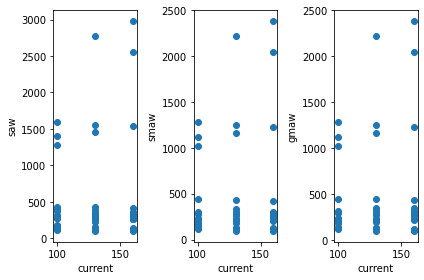



	Voltage vs Response values


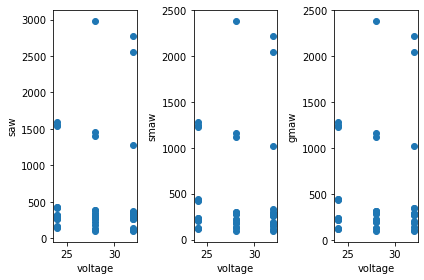



	Welding_speed vs Response values


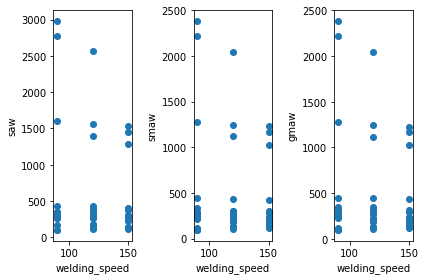



	Plate_thickness vs Response values


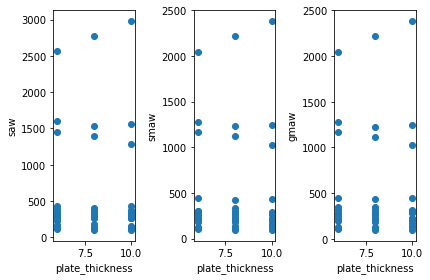

In [4]:
pos = 1
for i in range(4):
  print(f'\t{df2.columns[i].capitalize()} vs Response values')
  plt.figure()
  for j in range(8, 11):
    plt.subplot(1, 3, pos)
    plt.scatter(df2.iloc[:, i], df2.iloc[:, j])
    plt.ylabel(df2.columns[j])
    plt.xlabel(df2.columns[i])
    pos += 1
  plt.tight_layout()
  plt.show()
  print('\n')
  pos = 1

Generate the necessary variables for modeling

In [10]:
X1 = df2.iloc[:, :8]
X = X1.to_numpy()
y1 = df2.iloc[:, -4:]
y = y1.to_numpy()

In [11]:
def relu(x):
   return np.maximum(x, 0, x)

In [12]:
def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H

In [13]:
def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

Predicting individual response separately to optimize prediction

In [14]:
for i in range(y.shape[1]):
  cols = y[:, i]
  X_train, X_test, y_train, y_test = train_test_split(X, cols,random_state=1, test_size=0.2)

  input_size = X_train.shape[1]
  hidden_size = 5000
  input_weights = np.random.normal(size=[input_size,hidden_size])
  biases = np.random.normal(size=[hidden_size])

  output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)

  prediction = predict(X_test)
  print(f'Metrics for Response variable, {y1.columns[i].capitalize()}:')
  print(f'\tR^2: {(r2_score(prediction, y_test))}')
  print(f'\trmse: {np.sqrt(mean_squared_error(y_test, prediction))}')

Metrics for Response variable, Saw:
	R^2: 0.7403232271116015
	rmse: 237.4985269180565
Metrics for Response variable, Smaw:
	R^2: 0.8082376365080403
	rmse: 167.97521956532208
Metrics for Response variable, Gmaw:
	R^2: 0.9147425676671166
	rmse: 113.40985187010769
Metrics for Response variable, Gtaw:
	R^2: 0.875736205961994
	rmse: 93.1646002888756
